In [ ]:
# Cell 1: Setup and Data Loading
import os
import json
import wfdb
import numpy as np
import pandas as pd
import neurokit2 as nk
from scipy.signal import resample

# --- Configuration ---
RECORD_NAME = '100'
DATABASE_NAME = 'mitdb'
OUTPUT_DIR = f"processed_data/{RECORD_NAME}"

# Create the output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load the raw ECG record from PhysioNet
record = wfdb.rdrecord(RECORD_NAME, pn_dir=DATABASE_NAME)

# Extract the first lead signal and sampling frequency
signal = record.p_signal[:, 0]
fs = record.fs

print(f"Record '{RECORD_NAME}' loaded successfully.")
print(f"Signal shape: {signal.shape}, Sampling rate: {fs} Hz")

Record '100' loaded successfully.
Signal shape: (650000,), Sampling rate: 360 Hz


In [2]:
# Cell 2: Comprehensive ECG Processing
# Process the entire signal to get R-peaks and wave delineations
signals, info = nk.ecg_process(signal, sampling_rate=fs)

# The 'info' dictionary now contains the locations of R-peaks
rpeaks = info["ECG_R_Peaks"]

print(f"ECG processing complete. Found {len(rpeaks)} R-peaks.")

ECG processing complete. Found 2271 R-peaks.


In [3]:
# Cell 3: Extract Time-Domain & HRV Features

# The 'info' dictionary from ecg_process is all we need for HRV analysis
print("Calculating HRV features...")
hrv_time = nk.hrv_time(rpeaks, sampling_rate=fs, show=False)
hrv_freq = nk.hrv_frequency(rpeaks, sampling_rate=fs, show=False)
hrv_nonlinear = nk.hrv_nonlinear(rpeaks, sampling_rate=fs, show=False)

# Combine all HRV features into a single DataFrame
hrv_features = pd.concat([hrv_time, hrv_freq, hrv_nonlinear], axis=1)

print("✅ HRV features calculated successfully.")
display(hrv_features)

Calculating HRV features...
✅ HRV features calculated successfully.


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,794.619432,37.722005,19.659715,31.40665,18.276949,32.462245,16.126781,34.062791,32.163615,32.170662,...,1.842811,5.754765,1.276896,1.004569,1.378985,2.182704,1.779677,1.96557,4.060346,0.756328


In [4]:
# Cell 4: Assemble and Save the Feature-Based Dataset

# 1. Save the global HRV features
hrv_output_path = os.path.join(OUTPUT_DIR, "global_hrv_features.json")
hrv_features.to_json(hrv_output_path, orient='records', indent=4)
print(f"Global HRV features saved to: {hrv_output_path}")

# 2. Calculate beat-to-beat RR intervals
rr_intervals_ms = np.diff(rpeaks) / fs * 1000  # in milliseconds

# 3. Create a list of dictionaries for per-beat features
beat_features = [{"RR_ms": float(rr)} for rr in rr_intervals_ms]

# 4. Save the per-beat features
beat_output_path = os.path.join(OUTPUT_DIR, "beat_features.json")
with open(beat_output_path, "w") as f:
    json.dump(beat_features, f, indent=4)
    
print(f"Saved {len(beat_features)} per-beat feature vectors to: {beat_output_path}")

Global HRV features saved to: processed_data/100\global_hrv_features.json
Saved 2270 per-beat feature vectors to: processed_data/100\beat_features.json


✅ Saved raw beat segments to: processed_data/100\beat_segments.npy
   - Shape of the saved array: (2271, 187) (num_beats, length)


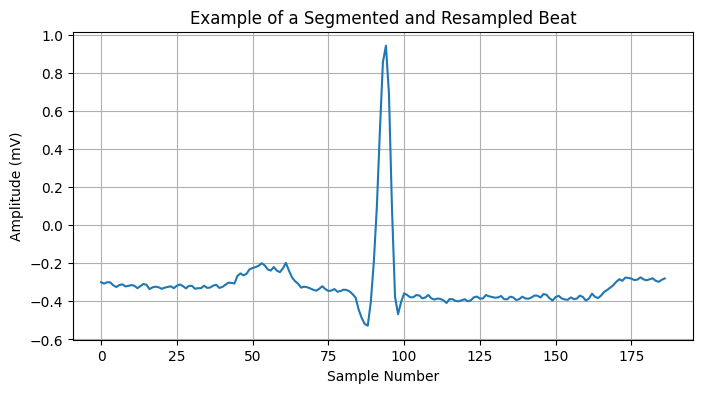

In [6]:
# Cell 5: Prepare and Save the Signal-Based Dataset
import matplotlib.pyplot as plt
def segment_and_normalize_beats(signal, rpeaks, fs, window_size=0.8, resample_length=187):
    """
    Segments heartbeats from a signal, centers them, and resamples to a fixed length.
    A resample_length of 187 is common in many papers (e.g., for MIT-BIH).
    """
    half_window = int(window_size * fs / 2)
    beats = []
    
    for r in rpeaks:
        start, end = r - half_window, r + half_window
        if start >= 0 and end < len(signal):
            beat = signal[start:end]
            # Resample the beat to the desired fixed length
            beat_resampled = resample(beat, resample_length)
            beats.append(beat_resampled)
            
    return np.array(beats)

# Use the rpeaks from Cell 2 to segment the original (not cleaned) signal
beat_segments = segment_and_normalize_beats(signal, rpeaks, fs)

# Save the array of beat segments
beats_output_path = os.path.join(OUTPUT_DIR, "beat_segments.npy")
np.save(beats_output_path, beat_segments)

print(f"✅ Saved raw beat segments to: {beats_output_path}")
print(f"   - Shape of the saved array: {beat_segments.shape} (num_beats, length)")

# Let's visualize one of the segmented beats to verify
plt.figure(figsize=(8, 4))
plt.plot(beat_segments[5])
plt.title("Example of a Segmented and Resampled Beat")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()